In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.utils.data as utils

from cheak_tools import cheak_type, cheak_interval, cheak_range
# see Cheak_tools.ipynb in https://github.com/Dogiko/Some-Tools/

from torch_refiner import LinearRefiner
# see https://github.com/Dogiko/Linear-Refiner

from torch_expander import LinearExpander
# see https://github.com/Dogiko/Layer-Expander

torch.set_default_tensor_type(torch.FloatTensor)

In [2]:
class FCNet(torch.nn.Module):
    def __init__(self, architecture, activation_function = torch.tanh):
        super(FCNet, self).__init__()
        
        for l in range(len(architecture) - 1):
            cheak_range(architecture[l], 1)
        
        self.fc_modules = torch.nn.ModuleList()
        for l in range(len(architecture) - 1):
            self.fc_modules.append(torch.nn.Linear(architecture[l], architecture[l+1]))
        
        self.activation_function = activation_function
    
    def get_layers_num(self):
        return (len(self.fc_modules))
    
    def get_architecture(self):
        output = ()
        for l in range(self.get_layers_num()):
            output += (self.fc_modules[l].in_features, )
        
        output += (self.fc_modules[-1].out_features, )
        return output
    
    def forward(self, x):
        for l in range(self.get_layers_num() - 1):
            x = self.fc_modules[l](x)
            x = self.activation_function(x)
        
        x = self.fc_modules[-1](x)
        return x
    
    def partial_forward(self, x, hidden_layer_idx):
        for l in range(hidden_layer_idx+1):
            x = self.fc_modules[l](x)
            x = self.activation_function(x)
        
        return x

class DoTorch():
    def __init__(self):
        self.train_loader = None
        self.valid_loader = None
        self.tests_loader = None # tests : using five words, same as train and valid
        self.net = None
        self.optimizer = None
        self.criterion = None
        self.record = None
        self.lr_multi = 0.1
    
    def set_train_loader(self, train_loader):
        cheak_type(train_loader, utils.dataloader.DataLoader)
        
        self.train_loader = train_loader
    
    def set_valid_loader(self, valid_loader):
        cheak_type(valid_loader, utils.dataloader.DataLoader)
        
        self.valid_loader = valid_loader
    
    def set_tests_loader(self, tests_loader):
        cheak_type(tests_loader, utils.dataloader.DataLoader)
        
        self.tests_loader = tests_loader
    
    def set_data(self, train_data, valid_data = None, tests_data = None, batch_size=1, shuffle=True, drop_last=True):
        cheak_type(train_data, utils.dataset.TensorDataset)
        cheak_type(valid_data, (utils.dataset.TensorDataset, type(None), float))
        cheak_type(tests_data, (utils.dataset.TensorDataset, type(None)))
        cheak_range(batch_size, mini=1)
        
        if valid_data is not None:
            try:
                cheak_interval(valid_data, 0, 1)
                # if valid_data is a ratio (0~1), get valid_data from part of train_data
                valid_len = max(1, int(len(train_data)*valid_data))
                split_data = utils.dataset.random_split(train_data, [len(train_data)-valid_len, valid_len])
                train_data = split_data[0]
                valid_data = split_data[1]
            except:
                pass
            
            self.set_valid_loader(utils.DataLoader(valid_data, batch_size=min(batch_size, len(valid_data)),
                                                   shuffle=shuffle, drop_last=drop_last))
        
        self.set_train_loader(utils.DataLoader(train_data, batch_size=min(batch_size, len(train_data)),
                                               shuffle=shuffle, drop_last=drop_last))
        if tests_data is not None:
            self.set_tests_loader(utils.DataLoader(tests_data, batch_size=min(batch_size, len(tests_data)),
                                                   shuffle=shuffle, drop_last=drop_last))
    
    def set_net(self, net):
        cheak_type(net, torch.nn.Module)
        
        self.net = net
    
    def set_criterion(self, criterion):
        cheak_type(criterion, torch.nn.Module)
        
        self.criterion = criterion
    
    def set_optimizer(self, optimizer):
        cheak_type(optimizer, torch.optim.Optimizer)
        
        self.optimizer = optimizer
    
    def one_step(self, _input, labels):
        self.optimizer.zero_grad()
        loss = self.criterion(self.net(_input), labels)
        loss.backward()
        self.optimizer.step()
        return loss.data
    
    def epoch_fit(self, loss_detail=False):
        loss_record = torch.zeros([len(self.train_loader)])
        for b, data in enumerate(self.train_loader):
            _input, labels = data
            loss_record[b] = self.one_step(_input, labels)
        
        if loss_detail:
            return loss_record
        else:
            return loss_record.mean()
    
    def evaluate(self, batchs = None):
        if batchs is None:
            batchs = len(self.valid_loader)
        
        cheak_range(batchs, 1)
        
        loss_record = []
        for b, data in enumerate(self.valid_loader):
            _input, labels = data
            loss_record.append(self.criterion(self.net(_input), labels))
            if b == batchs-1:
                break
        
        return torch.tensor(loss_record).mean()
    
    def test(self, batchs = None):
        if batchs is None:
            batchs = len(self.tests_loader)
        
        cheak_range(batchs, 1)
        
        loss_record = []
        for b, data in enumerate(self.tests_loader):
            _input, labels = data
            loss_record.append(self.criterion(self.net(_input), labels))
            if b == batchs-1:
                break
        
        return torch.tensor(loss_record).mean()
        
    
    def fit(self, epochs, loss_detail=False):
        cheak_interval(epochs, 1) # epochs should be an positive int
        
        loss = {}
        if loss_detail:
            loss["train"] = torch.zeros([epochs, len(self.train_loader)])
        else:
            loss["train"] = torch.zeros([epochs])
        
        if self.valid_loader is not None:
            loss["valid"] = torch.zeros([epochs])
        
        for e in range(epochs):
            loss["train"][e] = self.epoch_fit(loss_detail=loss_detail)
            if self.valid_loader is not None:
                loss["valid"][e] = self.evaluate()
        
        return loss
    
    def set_lr_multi(self, _input):
        cheak_interval(_input, mini=0.)
        
        self.lr_multi = _input
    
    def neuron_refine(self, layer_idx, drop=1, threshold=0.001, collinear_cut=None,
                      quick=True, data_set="t", lr_multi = None):
        cheak_range(layer_idx, mini=0, maxi=self.net.get_layers_num()-2)
        
        if lr_multi == None:
            lr_multi = self.lr_multi
        
        li=layer_idx
        refiner = LinearRefiner(self.net.fc_modules[li+1])
        refiner.reset()
        if data_set == "t":
            for i, data in enumerate(self.train_loader):
                _input, _ = data
                refiner.data_input(self.net.partial_forward(_input, layer_idx).data)
        elif data_set == "v":
            for i, data in enumerate(self.valid_loader):
                _input, _ = data
                refiner.data_input(self.net.partial_forward(_input, layer_idx).data)
        else:
            raise ValueError("data_set error, except 't'(train) or 'v'(valid), got %s" %(data_set))
        
        if collinear_cut is None:
            result = refiner.refine(drop, quick)
        else:
            result, _ = refiner.collinear_cut(method=collinear_cut, threshold=threshold,
                                              quick=quick, drop_limit=drop)
        
        remain_idx, out_weight, out_bias, _, _ = result
        in_weight = self.net.fc_modules[li].weight.data[remain_idx]
        in_bias = self.net.fc_modules[li].bias.data[remain_idx]
        self.net.fc_modules[li] = torch.nn.Linear(in_weight.shape[1], in_weight.shape[0])
        self.net.fc_modules[li].weight.data = in_weight
        self.net.fc_modules[li].bias.data = in_bias
        self.net.fc_modules[li+1] = torch.nn.Linear(out_weight.shape[1], out_weight.shape[0])
        self.net.fc_modules[li+1].weight.data = out_weight
        self.net.fc_modules[li+1].bias.data = out_bias
        new_optim = type(self.optimizer)(self.net.parameters())
        new_optim.defaults.update(self.optimizer.defaults)
        new_optim.param_groups[0].update(self.optimizer.defaults)
        new_optim.param_groups[0]['lr'] *= lr_multi
        self.set_optimizer(new_optim)
    
    def neuron_hyperplasia(self, layer_idx, _add=1, candidate_num=None, weighted=True,
                           std=None, epsilon=0., lr_multi = None):
        cheak_range(layer_idx, mini=0, maxi=self.net.get_layers_num()-2)
        cheak_interval(epsilon, mini=0., left_close=True)
        
        if lr_multi == None:
            lr_multi = self.lr_multi
        
        if candidate_num is None:
            candidate_num = _add
            weighted = False
        
        li=layer_idx
        
        ori_out_weight = self.net.fc_modules[li+1].weight.data
        ori_out_bias = self.net.fc_modules[li+1].bias.data
        
        in_features = self.net.fc_modules[li].in_features
        ori_features = self.net.fc_modules[li].out_features
        out_features = self.net.fc_modules[li+1].out_features
        
        if std is None:
            std = np.sqrt(1/(3*(ori_features + _add)))
        
        linear_expander = LinearExpander(self.net.fc_modules[li], self.net.activation_function,
                                         candidate_num, std=std)
        if weighted:
            for i, data in enumerate(self.train_loader):
                _input, _ = data
                linear_expander.data_input(self.net.partial_forward(_input, li-1))
        
        self.net.fc_modules[li] = linear_expander.expand(_add, weighted)
        
        self.net.fc_modules[li+1] = torch.nn.Linear(ori_features+_add, out_features)
        self.net.fc_modules[li+1].weight.data[:, :ori_features] = ori_out_weight
        self.net.fc_modules[li+1].weight.data[:, ori_features:] *= epsilon
        self.net.fc_modules[li+1].bias.data = ori_out_bias
        
        new_optim = type(self.optimizer)(self.net.parameters())
        new_optim.defaults.update(self.optimizer.defaults)
        new_optim.param_groups[0].update(self.optimizer.defaults)
        new_optim.param_groups[0]['lr'] *= lr_multi
        self.set_optimizer(new_optim)
    
    def neuron_adjust(self, layer_idx, neuron_num, quick=True, data_set="t", epsilon=0., lr_multi=None):
        cheak_range(layer_idx, mini=0, maxi=self.net.get_layers_num()-2)
        cheak_range(neuron_num, mini=1)
        
        exceed = neuron_num - self.net.get_architecture()[layer_idx+1]
        if exceed>0:
            self.neuron_hyperplasia(layer_idx=layer_idx, _add=exceed, epsilon=epsilon)
        elif exceed<0:
            self.neuron_refine(layer_idx=layer_idx, drop=-exceed, quick=quick, data_set=data_set, lr_multi=lr_multi)
    
    def architecture_adjust(self, layers, neurons, quick=True, data_set="t", epsilon=0., lr_multi=None):
        layer_iter = iter(layers)
        neuron_iter = iter(neurons)
        while True:
            try:
                li = next(layer_iter)
                n = next(neuron_iter)
            except:
                break
            
            self.neuron_adjust(layer_idx=li, neuron_num=n, quick=quick, data_set=data_set
                               , epsilon=epsilon, lr_multi=lr_multi)

## Simple case

odd or even

In [171]:
foo = DoTorch()

x = np.arange(600)-299
x = x/100
y = np.zeros((600))
y[:] = 1* (np.ceil(x) %2)
x = x.reshape(600,1)
x = Variable(torch.from_numpy(x).type(torch.FloatTensor))
y = Variable(torch.from_numpy(y).type(torch.LongTensor))
train = utils.TensorDataset(x, y)

foo.set_net(FCNet((1,5,2)))
foo.set_data(train_data=train, valid_data=0.1, batch_size=60)
foo.set_criterion(torch.nn.CrossEntropyLoss())
foo.set_optimizer(torch.optim.Adam(foo.net.parameters(), lr = 0.1))

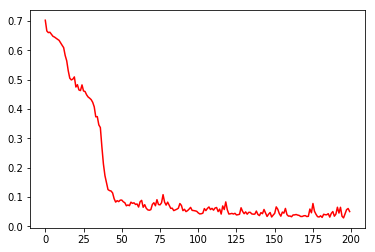

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


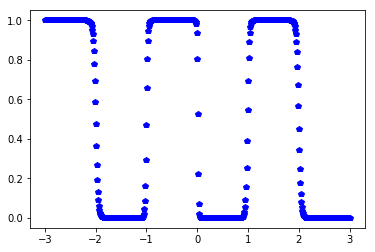

In [172]:
record = foo.fit(200)

plt.plot(range(len(record['valid'].data)), record['train'].data.numpy(), "r")
plt.show()

plt.plot(x.data.numpy().reshape(-1), torch.nn.Softmax()(foo.net(x)).data.numpy()[:,0], "bp")
plt.show()

## Find suitable architecture

In [17]:
foo = DoTorch()

x = np.arange(600)-299
x = x/100
y = np.zeros((600))
y[:] = 1* (np.ceil(x) %2)
x = x.reshape(600,1)
x = Variable(torch.from_numpy(x).type(torch.FloatTensor))
y = Variable(torch.from_numpy(y).type(torch.LongTensor))
train = utils.TensorDataset(x, y)

foo.set_net(FCNet((1,1,2)))
foo.set_data(train_data=train, valid_data=0.1, batch_size=60)
foo.set_criterion(torch.nn.CrossEntropyLoss())
foo.set_optimizer(torch.optim.Adam(foo.net.parameters(), lr = 0.1))

foo.fit(100)

for t in range(5):
    foo.neuron_hyperplasia(0, 5, candidate_num=10)
    foo.fit(100)
    foo.neuron_refine(0, drop=6, collinear_cut='vr')
    print(foo.net.get_architecture(), foo.evaluate())

(1, 4, 2) tensor(0.4266)
(1, 5, 2) tensor(0.0520)
(1, 5, 2) tensor(0.0311)
(1, 5, 2) tensor(0.0263)
(1, 5, 2) tensor(0.0260)


## MNIST

In [6]:
foo = DoTorch()

x = np.load('../mnist-npy/train_data.npy')/255
x = Variable(torch.from_numpy(x).type(torch.FloatTensor))
y = np.load('../mnist-npy/train_label.npy').argmax(axis=1)
y = Variable(torch.from_numpy(y).type(torch.LongTensor))
train = utils.TensorDataset(x, y)

x = np.load('../mnist-npy/test_data.npy')/255
x = Variable(torch.from_numpy(x).type(torch.FloatTensor))
y = np.load('../mnist-npy/test_label.npy').argmax(axis=1)
y = Variable(torch.from_numpy(y).type(torch.LongTensor))
test = utils.TensorDataset(x, y)

foo.set_net(FCNet((784,5,10)))
foo.set_data(train_data=train, valid_data=0.1, tests_data=test, batch_size=6000)
foo.set_criterion(torch.nn.CrossEntropyLoss())
foo.set_optimizer(torch.optim.Adam(foo.net.parameters(), lr = 0.01, betas=(0.9, 0.999)))

foo.fit(50)

for t in range(5):
    foo.neuron_hyperplasia(0, 5, candidate_num=10)
    foo.fit(50)
    foo.neuron_refine(0, 5, data_set="v")
    print(foo.net.get_architecture(), foo.evaluate())
    
    datums = 0.
    hit = 0.
    for b, data in enumerate(foo.tests_loader):
        _input, labels = data
        datums += _input.size()[0]
        hit += (foo.net(_input).data.max(1)[1] == labels).sum()

    print(hit.type(torch.FloatTensor)/datums)


(784, 5, 10) tensor(0.5054)
tensor(0.8555)
(784, 5, 10) tensor(0.4955)
tensor(0.8585)
(784, 5, 10) tensor(0.4752)
tensor(0.8623)
(784, 5, 10) tensor(0.4641)
tensor(0.8663)
(784, 5, 10) tensor(0.4552)
tensor(0.8658)


In [46]:
datums = 0.
hit = 0.
for b, data in enumerate(foo.tests_loader):
    _input, labels = data
    datums += _input.size()[0]
    hit += (foo.net(_input).data.max(1)[1] == labels).sum()

hit.type(torch.FloatTensor)/datums

tensor(0.9243)

tensor(47372)